In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
from tqdm.notebook import tqdm
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import wandb

from sklearn.datasets import fetch_openml

device = 'cuda' if torch.cuda.is_available() else 'cpu'

plt.style.use('seaborn')
np.__version__, device

('1.21.2', 'cuda')

## 4.1

In [2]:
X_train, y_train = np.load('./Data/MNIST/train_images.npy').reshape(-1, 28, 28), np.load('./Data/MNIST/train_labels.npy').reshape(-1)
X_test, y_test = np.load('./Data/MNIST/test_images.npy').reshape(-1, 28, 28), np.load('./Data/MNIST/test_labels.npy').reshape(-1)

y_train, y_test = y_train.astype(np.int64), y_test.astype(np.int64)

X_train.shape, y_train.shape

((60000, 28, 28), (60000,))

<AxesSubplot:ylabel='count'>

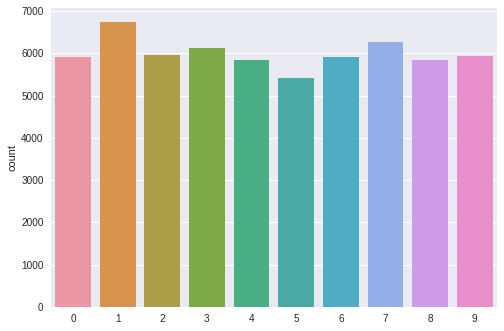

In [3]:
sea.countplot(x = y_train)

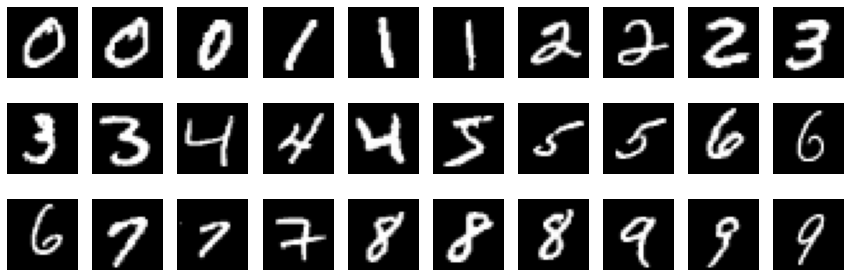

In [4]:
counter = 1
plt.figure(figsize=(15, 5))
for i in range(0, 10):
    x_i = X_train[y_train == i][:3]
    for j, img in enumerate(x_i):
        plt.subplot(3, 10, counter)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        counter += 1

plt.show()

In [5]:
from sklearn.model_selection import train_test_split

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape


((60000, 28, 28), (60000,), (5000, 28, 28), (5000,), (5000, 28, 28), (5000,))

## 4.2

In [6]:
class DigitDataset:
    def __init__(self, X, y, transform=None):
        self.transform = transform
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x, y = self.X[idx], self.y[idx]
        if self.transform:
            x = self.transform(x)

        return x, y


train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0, 1)
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0, 1)

])

batch_size = 64

train_dataset = DigitDataset(X_train, y_train, train_transform)
val_dataset = DigitDataset(X_val, y_val, val_transform)
test_dataset = DigitDataset(X_test, y_val, val_transform)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)



In [7]:
a, b = next(iter(train_loader))
a.shape, b.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [8]:
class Model(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.params = params
        
        self.layer1 = self.get_layers(1, 32)
        self.layer2 = self.get_layers(32, 64)
        self.layer3 = self.get_layers(64, 128)

        self.drop = nn.Dropout(0.2) if self.params['use_dropout'] else nn.Identity()
        self.fc1 = nn.Linear(128 * 3 * 3, 128 * 1 * 1)
        self.fc2 = nn.Linear(128, 10)

    def get_layers(self, in_c, out_c):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=self.params['kernel_size'], stride = 1, padding=self.params['padding']),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        # 1, 28, 28
        x = self.layer1(x) # 32, 14, 14
        x = self.layer2(x) # 64, 7, 7
        x = self.drop(x)
        x = self.layer3(x) # 128, 3, 3

        x = x.view(-1, 128 * 3 * 3) # 128 * 3 * 3

        x = self.drop(x)

        x = nn.ReLU()(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        return x



In [9]:

from sklearn.metrics import accuracy_score

class Trainer:
    def __init__(self,
                 model,
                 loss_fxn,
                 train_loader,
                 val_loader,
                 device,
                 params,
                 logger):

        self.device = device
        self.params = params
        self.logger = logger
        self.model = model.to(self.device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.loss_fxn = loss_fxn
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr = self.params['lr'])

    def training_step(self, x, y):
        y_pred = self.model(x)
        loss = self.loss_fxn(y_pred, y)
        acc = accuracy_score(y.detach().cpu(), torch.argmax(y_pred, axis=-1).detach().cpu())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss, acc

    def val_step(self, x, y):
        with torch.no_grad():
            y_pred = self.model(x)
        loss = self.loss_fxn(y_pred, y)
        acc = accuracy_score(y.detach().cpu(), torch.argmax(y_pred, axis=-1).detach().cpu())
        return loss, acc

    def go_over_batch(self, loader, step_fxn):
        loss, acc = 0, 0
        for x, y in tqdm(loader):
            x, y = x.to(self.device), y.to(self.device)
            l, a = step_fxn(x, y)
            loss, acc = loss + l, acc + a
            
        return loss/len(loader), acc/len(loader)

    def train(self):

        for epoch in tqdm(range(self.params['epoch'])):
            train_loss, train_acc = self.go_over_batch(self.train_loader, self.training_step)
            val_loss, val_acc = self.go_over_batch(self.val_loader, self.val_step)

            print(f"[Epoch: {epoch}] Train:[loss:{train_loss:.3f} acc:{train_acc:.3f}] Val:[loss:{val_loss:.3f} acc:{val_acc:.3f}]")
            
            if self.logger:
                self.logger.log({'train_loss': train_loss, 'train_acc': train_acc, 
                                'val_loss':val_loss, 'val_acc':val_acc})
        if self.logger:     
            self.logger.finish()

In [11]:

params = {
    'lr' : 1e-4,
    'batch_size': 256,
    'epoch': 20, 
    'use_dropout': True,
    'kernel_size': 3,
    'padding': 1
}

wandb.init(
    project="SMAI-A3-CNN",
    config=params,
    name=f"kernel_size={params['kernel_size']}, padding={params['padding']}"
    
)

trainer = Trainer(
    model = Model(params),
    loss_fxn = nn.CrossEntropyLoss(),
    train_loader = train_loader,
    val_loader = val_loader,
    device = device, 
    params = params, 
    logger = None
)

trainer.train()



wandb: wandb version 0.15.12 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

[Epoch: 0] Train:[loss:0.633 acc:0.800] Val:[loss:0.201 acc:0.938]


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

[Epoch: 1] Train:[loss:0.167 acc:0.949] Val:[loss:0.122 acc:0.964]


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

[Epoch: 2] Train:[loss:0.124 acc:0.961] Val:[loss:0.095 acc:0.969]


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

[Epoch: 3] Train:[loss:0.101 acc:0.969] Val:[loss:0.076 acc:0.976]


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

[Epoch: 4] Train:[loss:0.085 acc:0.974] Val:[loss:0.066 acc:0.978]


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

[Epoch: 5] Train:[loss:0.075 acc:0.977] Val:[loss:0.067 acc:0.978]


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

[Epoch: 6] Train:[loss:0.064 acc:0.980] Val:[loss:0.054 acc:0.984]


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

[Epoch: 7] Train:[loss:0.059 acc:0.981] Val:[loss:0.045 acc:0.985]


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

[Epoch: 8] Train:[loss:0.054 acc:0.983] Val:[loss:0.052 acc:0.981]


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

[Epoch: 9] Train:[loss:0.049 acc:0.985] Val:[loss:0.046 acc:0.985]


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

[Epoch: 10] Train:[loss:0.044 acc:0.987] Val:[loss:0.042 acc:0.986]


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

[Epoch: 11] Train:[loss:0.041 acc:0.987] Val:[loss:0.042 acc:0.986]


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

[Epoch: 12] Train:[loss:0.039 acc:0.988] Val:[loss:0.043 acc:0.986]


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

[Epoch: 13] Train:[loss:0.036 acc:0.989] Val:[loss:0.035 acc:0.990]


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

[Epoch: 14] Train:[loss:0.035 acc:0.989] Val:[loss:0.036 acc:0.988]


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

[Epoch: 15] Train:[loss:0.033 acc:0.989] Val:[loss:0.035 acc:0.990]


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

[Epoch: 16] Train:[loss:0.030 acc:0.990] Val:[loss:0.036 acc:0.987]


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

[Epoch: 17] Train:[loss:0.030 acc:0.990] Val:[loss:0.030 acc:0.989]


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

[Epoch: 18] Train:[loss:0.028 acc:0.991] Val:[loss:0.029 acc:0.990]


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

[Epoch: 19] Train:[loss:0.025 acc:0.992] Val:[loss:0.031 acc:0.990]


## 4.4

In [12]:
def test_model(model, loader, give_loss=False):
    y_test_pred = []
    loss = 0
    for x, y in tqdm(loader):
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss += nn.CrossEntropyLoss()(y_pred, y)
        y_pred = torch.argmax(y_pred, -1).cpu().numpy()
        y_test_pred.extend(y_pred)
        
        
    if give_loss:
        return y_test_pred, loss/len(loader)
    else:
        return y_test_pred


In [13]:
from sklearn.metrics import classification_report, confusion_matrix

model = torch.load('cnn_model.pth')
model = model.to(device)

y_test_pred = test_model(model, test_loader, give_loss=False)


  0%|          | 0/79 [00:00<?, ?it/s]

In [14]:
cf = confusion_matrix(y_test, y_test_pred)

print(classification_report(y_test, y_test_pred))


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       498
           1       0.99      1.00      0.99       558
           2       0.99      0.99      0.99       516
           3       0.99      0.99      0.99       535
           4       0.98      0.98      0.98       472
           5       0.99      0.99      0.99       442
           6       0.99      0.99      0.99       480
           7       0.98      0.98      0.98       534
           8       0.98      0.98      0.98       456
           9       0.98      0.96      0.97       509

    accuracy                           0.99      5000
   macro avg       0.99      0.99      0.99      5000
weighted avg       0.99      0.99      0.99      5000



<AxesSubplot:>

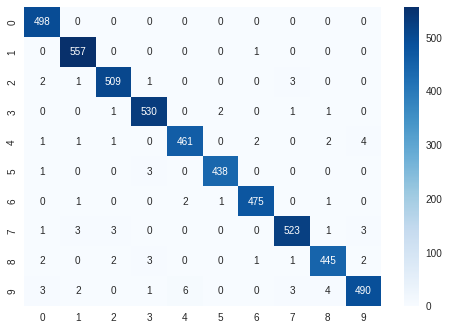

In [15]:
sea.heatmap(cf, annot=True, fmt='d', cmap='Blues')

## Analysis

From the above confusion matrix, we can observe that specific instances like 9 are being predicted as 4, 7 is being predicted as 2 as well as 1. This is because, for example, 9 sometimes looks like 4 or most commonly 7 can be mistaken as a 1 etc. Because of these inherent confusions, the model get confused too and makes wrong predictions. 

## 4.5 

In [16]:
class DigitDataset:
    def __init__(self, X, y, transform=None):
        self.transform = transform
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x, y = self.transform(self.X[idx]), self.y[idx]
        x += torch.rand_like(x)/2
        return x, y


train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0, 1)
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0, 1)

])

batch_size = 512

train_dataset = DigitDataset(X_train, y_train, train_transform)
# val_dataset = DigitDataset(X_val, y_val, val_transform)
test_dataset = DigitDataset(X_test, y_test, val_transform)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = False)
# val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)



In [17]:
params = {
    'lr' : 1e-4,
    'batch_size': 128,
    'epoch': 10, 
    'use_dropout': True,
    'kernel_size': 3,
    'padding': 1
}

wandb.init(
    project="SMAI-A3-CNN",
    config=params,
    name=f"kernel_size={params['kernel_size']}, padding={params['padding']}"
    
)

trainer = Trainer(
    model = Model(params),
    loss_fxn = nn.CrossEntropyLoss(),
    train_loader = train_loader,
    val_loader = test_loader,
    device = device, 
    params = params, 
    logger = None
)

trainer.train()

wandb: wandb version 0.15.12 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

[Epoch: 0] Train:[loss:1.899 acc:0.416] Val:[loss:0.991 acc:0.689]


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

[Epoch: 1] Train:[loss:0.721 acc:0.774] Val:[loss:0.504 acc:0.839]


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

[Epoch: 2] Train:[loss:0.439 acc:0.866] Val:[loss:0.325 acc:0.901]


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

[Epoch: 3] Train:[loss:0.317 acc:0.903] Val:[loss:0.249 acc:0.922]


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

[Epoch: 4] Train:[loss:0.255 acc:0.922] Val:[loss:0.202 acc:0.939]


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

[Epoch: 5] Train:[loss:0.216 acc:0.934] Val:[loss:0.177 acc:0.945]


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

[Epoch: 6] Train:[loss:0.190 acc:0.942] Val:[loss:0.153 acc:0.954]


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

[Epoch: 7] Train:[loss:0.171 acc:0.947] Val:[loss:0.138 acc:0.960]


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

[Epoch: 8] Train:[loss:0.156 acc:0.953] Val:[loss:0.126 acc:0.962]


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

[Epoch: 9] Train:[loss:0.146 acc:0.955] Val:[loss:0.115 acc:0.964]


In [18]:
from sklearn.metrics import classification_report

def test_model(model, loader):
    y_pred, y_true = [], []
    
    for x, y in tqdm(loader):
        x = x.to(device)
        y_pred.extend(torch.argmax(model(x).detach().cpu(), axis=-1))
        y_true.extend(y) 
        
    print(classification_report(y_true, y_pred))


test_model(trainer.model, val_loader)        

  0%|          | 0/79 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       482
           1       0.97      0.99      0.98       577
           2       0.94      0.95      0.95       516
           3       0.97      0.92      0.95       475
           4       0.96      0.97      0.96       510
           5       0.90      0.98      0.94       450
           6       0.95      0.96      0.96       478
           7       0.91      0.98      0.94       494
           8       0.99      0.81      0.89       518
           9       0.93      0.94      0.94       500

    accuracy                           0.95      5000
   macro avg       0.95      0.95      0.95      5000
weighted avg       0.95      0.95      0.95      5000

